In [61]:
require(data.table)
require(ggplot2)
require(reshape2)

In [62]:
#inDB = data.table(read.csv("adverity.csv"))

In [136]:
#inDB = data.table(read.csv("adverity2019.csv"))
inDB = data.table(read.csv("adverity2020.csv"))
#inDB = data.table(read.csv("adverity2021.csv"))
#inDB = data.table(read.csv("adverityoct2019.csv"))


In [137]:
inDB[is.na(inDB)] <- 0
inDB$Daily = as.Date(inDB$Daily, format = "%m/%d/%Y")

inDB$Month = format(inDB$Daily, format="%Y-%m-%d")

In [138]:
get_country = function(camp){
    s = strsplit(camp, "_")[[1]][3]
    return(s)
}
inDB$Country = apply(inDB[,"Campaign.Name"], 1, get_country)
inDB[Country == "Brasil", Country:= "BRA"]
inDB = inDB[!is.na(Country)]
inDB = inDB[Platform.Cost.... > 0]
country_list = inDB[, .(.N), by = Country]$Country
country_list

[1] "MEX"   "CENAM" "PRI"   "BRA"   "GTM"   "PAN"   "CRI"   "DOM"   "ARG"  
[10] "COL"   "SLV"   "ECU"   "HND"   "NIC"   "JAM"   "BHS"   "BMU"   "CHL"

In [139]:
cost_type = function(camp_s){
    type = "undefined"
    if (camp_s %like% "CPM"){
        type = "CPM"
    }
    if (camp_s %like% "CPV"){
        type = "CPV"
    }
    if (camp_s %like% "CPCV"){
        type = "CPCV"
    }
    if (camp_s %like% "CPE"){
        type = "CPE"
    }
    if (camp_s %like% "CPC_"){
        type = "CPC"
    }
    return(type)
}

cost_kpi = function(camp_s){
    type = "undefined"
    if (camp_s %like% "CPM"){
        type = "Impressions"
    }
    if (camp_s %like% "CPV"){
        type = "Video Views"
    }
    if (camp_s %like% "CPCV"){
        type = "Video Completions"
    }
    if (camp_s %like% "CPE"){
        type = "Engagements"
    }
    if (camp_s %like% "CPC_"){
        type = "Clicks"
    }
    return(type)
}

In [140]:
inDB[,"Cost.Type"] = apply(inDB[, "Campaign.Name"], 1, cost_type)
inDB[,"Cost.KPI"] = apply(inDB[, "Campaign.Name"], 1, cost_kpi)
inDB[, "Unit.KPI"] = as.numeric(0.0)

inDB[Campaign.Name %like% "Awareness", Cost.Type := "CPM"]
inDB[Campaign.Name %like% "Views", Cost.Type := "CPV"]
inDB[Campaign.Name %like% "Clics", Cost.Type := "CPE"]


In [141]:
inDB[Cost.Type == "CPCV", Unit.KPI:=as.numeric(inDB[Cost.Type =="CPCV", Video.Completions])]
inDB[Cost.Type == "CPC", Unit.KPI:=as.numeric(inDB[Cost.Type =="CPC", Clicks])]
inDB[Cost.Type == "CPV", Unit.KPI:=as.numeric(inDB[Cost.Type =="CPV", Video.Views])]
inDB[Cost.Type == "CPM", Unit.KPI:=as.numeric(inDB[Cost.Type =="CPM", Impressions])]
inDB[Cost.Type == "CPE", Unit.KPI:=as.numeric(inDB[Cost.Type =="CPE", Engagements])]


inDB[,"Unit.Cost"] = 0
inDB[Cost.Type == "CPM", Unit.Cost:=as.numeric(Platform.Cost....*1000/Unit.KPI)]
inDB[Cost.Type != "CPM", Unit.Cost:=as.numeric(Platform.Cost..../Unit.KPI)]

inDB = inDB[Cost.Type != "undefined"]

inDB[is.na(inDB)] <- 0

In [142]:
FacebookDB = inDB[Datasource %like% "Facebook*"]
AdwordsDB = inDB[Datasource %like% "Google*"]

In [143]:
central_goal = inDB[Cost.KPI != "undefined", .(Central.Goal = median(Unit.KPI), Central.Cost = median(Unit.Cost)), by=c("Month","Country", "Datasource", "Cost.Type")][order(Country)]
central_cost = inDB[Cost.KPI != "undefined", .(Central.Goal = median(Unit.KPI)), by=c("Month","Country", "Datasource", "Cost.KPI")][order(Country)]


global_mes = dcast(central_cost, Month + Country + Datasource  ~ Cost.KPI)
global_mes[is.na(global_mes)] <- 0

colnames(global_mes) = c("Month", "Country", "Datasource", "Central.Clicks", "Central.Engagements", "Central.Impressions", "Central.Video.Completions", "Central.Video.Views")
monthDB = inDB[, .(.N, Platform.Cost = sum(Platform.Cost....), Impressions = sum(Impressions), Clicks = sum(Clicks), Engagements = sum(Engagements), Video.Views = sum(Video.Views),Video.Completions=sum(Video.Completions), Unit.KPI = sum(Unit.KPI), Unit.Cost = sum(Platform.Cost....)/sum(Unit.KPI), Costs = sum(Platform.Cost....)), by=c("Month", "Datasource", "Country","Campaign.Name" ,"Cost.Type", "Cost.KPI")]

monthDB[is.na(monthDB)]<-0



mergedDB = merge(monthDB, central_goal)
finalDB = merge(mergedDB, global_mes, by=c("Datasource", "Month", "Country"), all.x=TRUE, allow.cartesian=TRUE)

finalDB$Eval1 = -1*finalDB$Unit.Cost /finalDB$Central.Cost
finalDB$Eval2 = finalDB$Impressions / finalDB$Central.Impressions
finalDB$Eval3 = finalDB$Clicks / finalDB$Central.Clicks
finalDB$Eval4 = finalDB$Engagements / finalDB$Central.Engagements
finalDB$Eval5 = finalDB$Video.Completions/ finalDB$Central.Video.Completions
finalDB$Eval6 = finalDB$Video.Views / finalDB$Central.Video.Views

finalDB[is.na(finalDB)] <- 0
finalDB[finalDB==Inf] <- 0


finalDB$EvalTotal = 0

finalDB[Cost.Type == "CPM", EvalTotal:= Eval1 + Eval2 + (0.1*Eval3) + (0.01*Eval4) + (0.001)*Eval5 + (0.0001*Eval6)]
finalDB[Cost.Type == "CPE", EvalTotal:= Eval1 + Eval4 + (0.1)*Eval6 + (0.01)*Eval5 + (0.001)*Eval3 + (0.0001)*Eval2]
finalDB[Cost.Type == "CPV", EvalTotal:= Eval1 + (0.1)*Eval4 + Eval6 + (0.01)*Eval5 + (0.001)*Eval3 + (0.0001)*Eval2]
finalDB[Cost.Type == "CPCV", EvalTotal:= Eval1 + (0.1)*Eval4 + (0.01)*Eval6 + Eval5 + (0.001)*Eval3 + (0.0001)*Eval2]
finalDB[Cost.Type == "CPC", EvalTotal:= Eval1 + (0.1)*Eval4 + (0.01)*Eval6 + Eval3 + (0.001)*Eval5 + (0.0001)*Eval2]

finalDB[Cost.Type == "CPM", second.Eval:= (0.1*Eval3) + (0.01*Eval4) + (0.001)*Eval5 + (0.0001*Eval6)]
finalDB[Cost.Type == "CPE", second.Eval:= (0.1)*Eval6 + (0.01)*Eval5 + (0.001)*Eval3 + (0.0001)*Eval2]
finalDB[Cost.Type == "CPV", second.Eval:= (0.1)*Eval4 + (0.01)*Eval5 + (0.001)*Eval3 + (0.0001)*Eval2]
finalDB[Cost.Type == "CPCV",second.Eval:= (0.1)*Eval4 + (0.01)*Eval6 +  (0.001)*Eval3 + (0.0001)*Eval2]
finalDB[Cost.Type == "CPC", second.Eval:= (0.1)*Eval4 + (0.01)*Eval6 +  (0.001)*Eval5 + (0.0001)*Eval2]

finalDB[Cost.Type == "CPM", first.Eval:= Eval2]
finalDB[Cost.Type == "CPE", first.Eval:= Eval4 ]
finalDB[Cost.Type == "CPV", first.Eval:= Eval6 ]
finalDB[Cost.Type == "CPCV", first.Eval:= Eval5 ]
finalDB[Cost.Type == "CPC", first.Eval:= Eval3 ]

presDB = finalDB[, .(Eval = median(EvalTotal), Central.Goal = median(Central.Goal), Total.Units = sum(Unit.KPI), Unit.Cost = sum(Costs)/sum(Unit.KPI), Central.Cost = median(Central.Cost)), by=c("Campaign.Name", "Country", "Cost.Type")][order(-Eval)]

scmin = min(presDB$Eval)
presDB$Eval = presDB$Eval - scmin


scmax = max(presDB$Eval)
presDB$Eval = log(ceiling(presDB$Eval*100 / scmax)+0.001)


liminf = median(presDB$Eval)*0.7
limsup = median(presDB$Eval)*1.3

presDB$Status = "Good"
presDB[Eval > limsup, Status:= "Great"]
presDB[Eval < liminf, Status:= "Could be Better"]

write.csv(presDB, "results.csv", row.names=FALSE)

Using Central.Goal as value column: use value.var to override.



In [144]:
write.csv(finalDB, "resultsfinalDB2020.csv", row.names=FALSE)
finalDB2020 = finalDB

In [167]:
finalDB = finalDBoct2019[EvalTotal >= 0]
finalDB2019 = finalDB2019[EvalTotal >= 0]
finalDB2020 = finalDB2020[EvalTotal >= 0]
finalDB2021 = finalDB2021[EvalTotal >= 0]

In [135]:
finalDB[order(-EvalTotal)]

Datasource,Month,Country,Cost.Type,Campaign.Name,Cost.KPI,N,Platform.Cost,Impressions,Clicks,⋯,Central.Video.Views,Eval1,Eval2,Eval3,Eval4,Eval5,Eval6,EvalTotal,second.Eval,first.Eval
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Facebook Ads Insights,2020-05-28,GTM,CPM,MCMMIA_2020_GTM_KELLOGGS_PRINGLES_SEASONAL_STAYHOME&CAEMEJOR_FACEBOOK_FACEBOOKANDINSTAGRAM_REACH_CPM_EVENINGME,Impressions,1,211.8100,550005,5233,⋯,0,-0.0009327418,2.6624310,0.000000e+00,14631.000000,0.000000,0,148.97150,1.463100e+02,2.6624310
Facebook Ads Insights,2020-05-28,GTM,CPM,MCMMIA_2020_GTM_KELLOGGS_CHOCOKRISPIS_SEASONAL_KOOLCHARAS_FACEBOOK_FACEBOOKANDINSTAGRAM_REACH_CPM_FAMILYBREAKFAST,Impressions,1,131.1900,284002,984,⋯,0,-0.0011188219,1.3747797,0.000000e+00,7400.500000,0.000000,0,75.37866,7.400500e+01,1.3747797
Facebook Ads Insights,2020-05-28,GTM,CPM,MCMMIA_2020_GTM_KELLOGGS_CHOCOKRISPIS_SEASONAL_CHOCOKRISPIS_FACEBOOK_FACEBOOK_REACH_CPM_FAMILYBREAKFAST,Impressions,1,65.4700,209043,1052,⋯,0,-0.0007585572,1.0119227,0.000000e+00,5202.500000,0.000000,0,53.03616,5.202500e+01,1.0119227
Facebook Ads Insights,2021-03-29,MEX,CPCV,MCMMX_2021_MEX_KELLOGGS_EXTRA_SEASONAL_EXTRADELICE_FACEBOOK_FACEBOOKANDINSTAGRAM_VIEWS_CPCV_AFTERNOONSNACK,Video Completions,1,683.7433,268874,1676,⋯,0,-1.1736484586,0.5904828,8.919638e-01,454.729128,2.160906,0,46.46112,4.547386e+01,2.1609057
Facebook Ads Insights,2021-02-25,MEX,CPM,MCMMX_2021_MEX_KELLOGGS_ZUCARITAS_SEASONAL_PURAGARRA_FACEBOOK_FACEBOOKANDINSTAGRAM_REACH_CPM_FAMILYBREAKFAST,Impressions,1,799.6889,1983815,7703,⋯,0,-0.0011779594,1.0000000,3.914126e+00,4442.947368,0.000000,0,45.81971,4.482089e+01,1.0000000
Facebook Ads Insights,2021-02-25,MEX,CPM,MCMMX_2021_MEX_KELLOGGS_MASTERBRAND_SEASONAL_DESPIERTAMUCHOMAS_FACEBOOK_FACEBOOKANDINSTAGRAM_REACH_CPM_BREAKFASTFORONE,Impressions,1,1033.4666,2725494,6776,⋯,0,-0.0011080558,1.3738650,3.443089e+00,4287.578947,0.000000,0,44.59286,4.322010e+01,1.3738650
Facebook Ads Insights,2020-05-28,GTM,CPM,MCMMIA_2020_GTM_KELLOGGS_SPECIALK_SEASONAL_REPOSICIONAMIENTO_FACEBOOK_FACEBOOK_REACH_CPM_BREAKFASTFORONE,Impressions,1,135.8000,250288,1282,⋯,0,-0.0013141392,1.2115790,0.000000e+00,4066.500000,0.000000,0,41.87526,4.066500e+01,1.2115790
Facebook Ads Insights,2021-03-30,MEX,CPCV,MCMMX_2021_MEX_KELLOGGS_EXTRA_SEASONAL_EXTRADELICE_FACEBOOK_FACEBOOKANDINSTAGRAM_VIEWS_CPCV_AFTERNOONSNACK,Video Completions,1,704.5534,259727,1504,⋯,0,-1.1396670903,0.6760969,8.218579e-01,392.737542,2.408338,0,40.54331,3.927464e+01,2.4083382
Facebook Ads Insights,2021-03-29,MEX,CPCV,MCMMX_2021_MEX_KELLOGGS_EXTRA_SEASONAL_EXTRA_FACEBOOK_FACEBOOKANDINSTAGRAM_VIDEOVIEWS_CPCV_BREAKFASTFORONE,Video Completions,2,428.6927,235998,1431,⋯,0,-0.7950544730,0.5182828,7.615753e-01,365.957328,2.000000,0,37.80149,3.659655e+01,2.0000000


In [ ]:
Eval

In [171]:
finalDB$lnEvalTotal = log(finalDB$EvalTotal)
finalDB2019$lnEvalTotal = log(finalDB2019$EvalTotal)
finalDBoct2019$lnEvalTotal = log(finalDBoct2019$EvalTotal)
finalDB2020$lnEvalTotal = log(finalDB2020$EvalTotal)
finalDB2021$lnEvalTotal = log(finalDB2021$EvalTotal)

In [178]:
sd(finalDB$EvalTotal)

[1] 2.138203

[1] "Standard Deviation"
[1] 2.138203


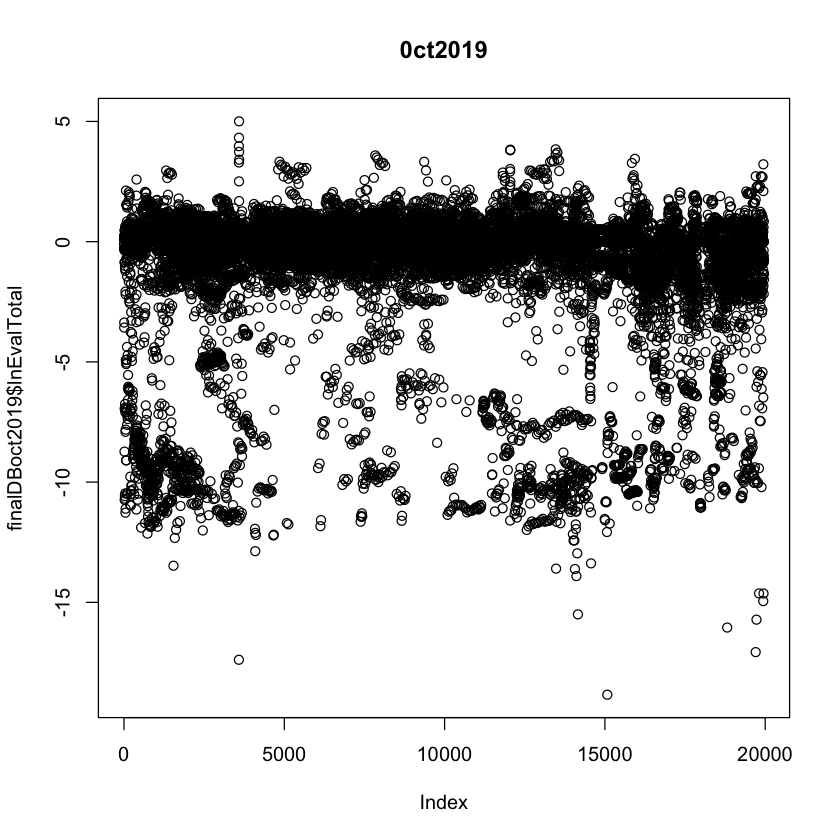

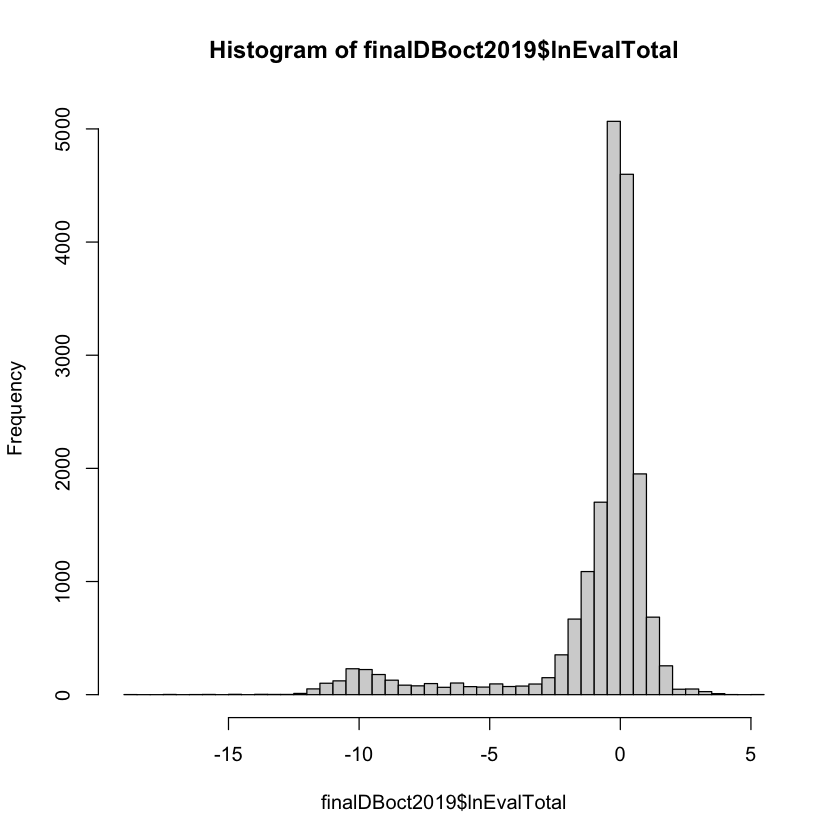

[1] "Standard Deviation"
[1] 2.323919


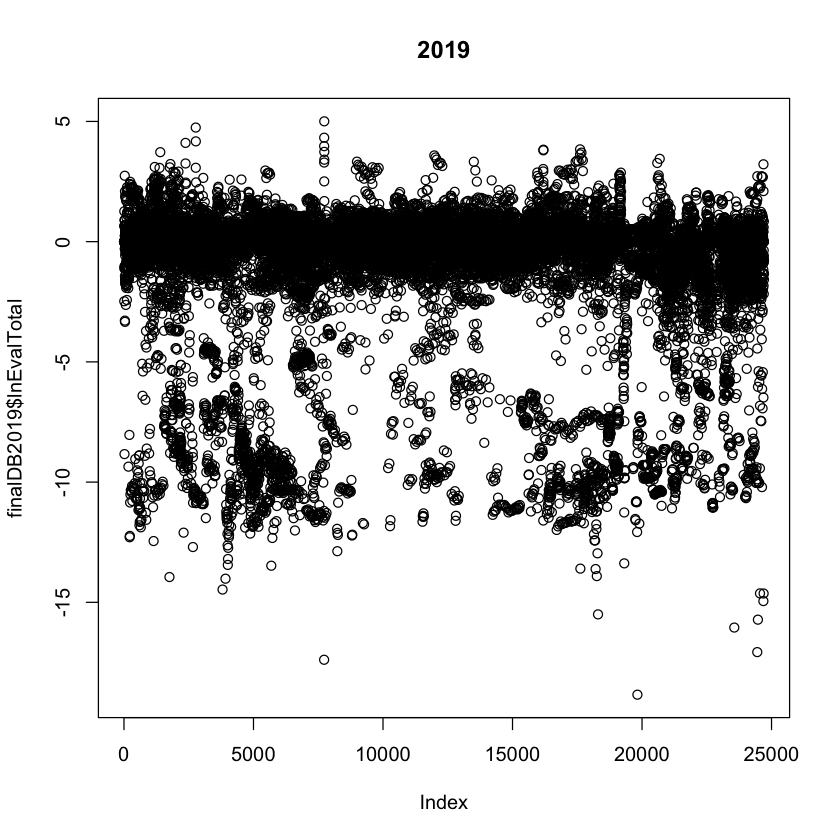

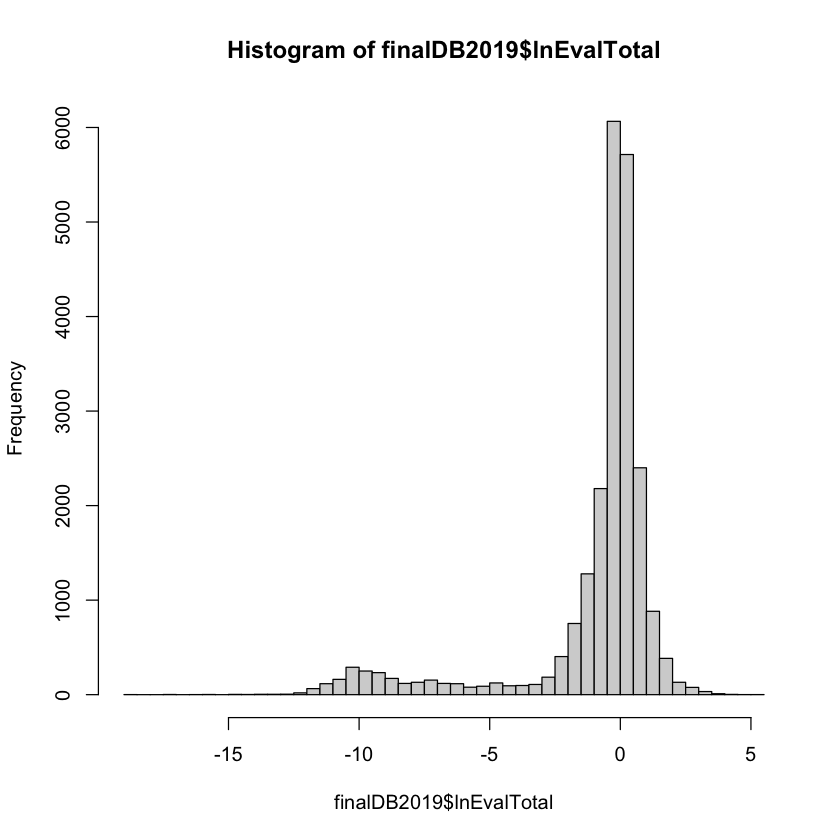

[1] "Standard Deviation"
[1] 2.138203


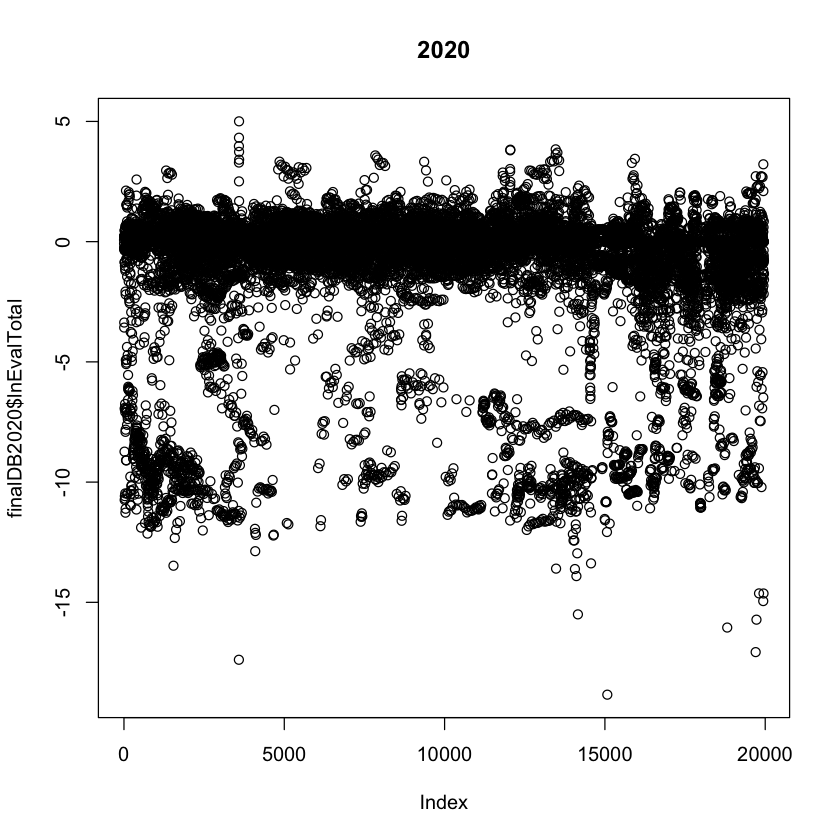

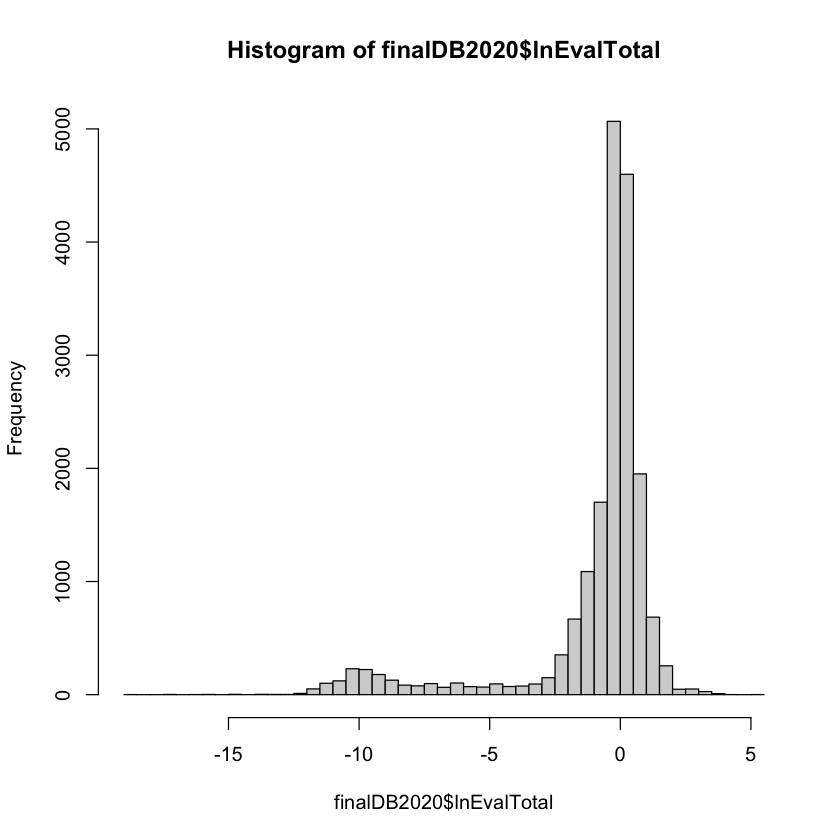

[1] "Standard Deviation"
[1] 2.263021


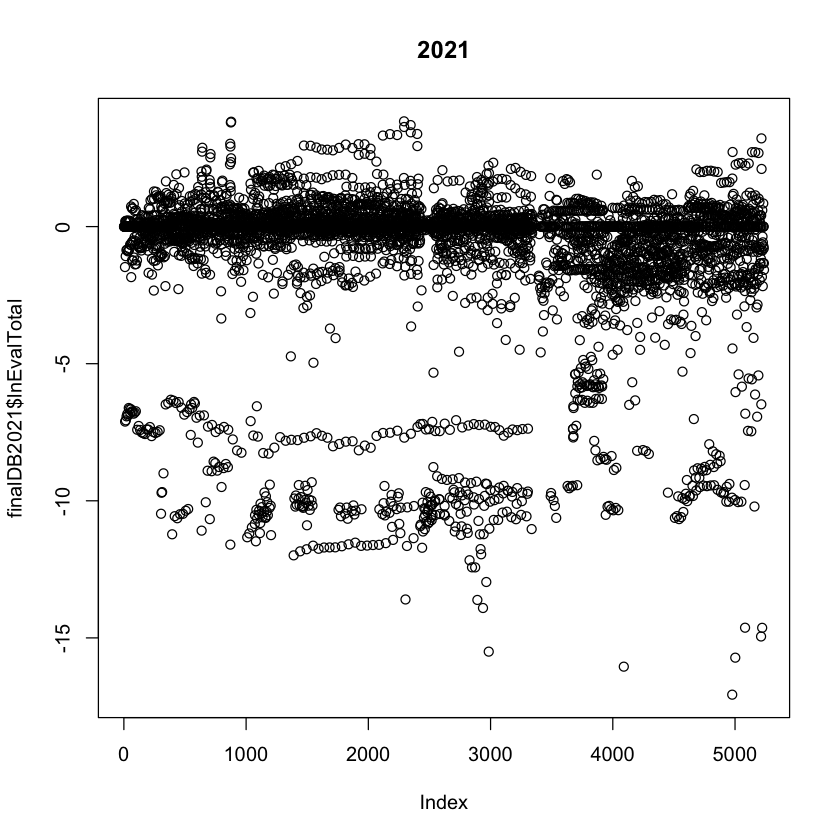

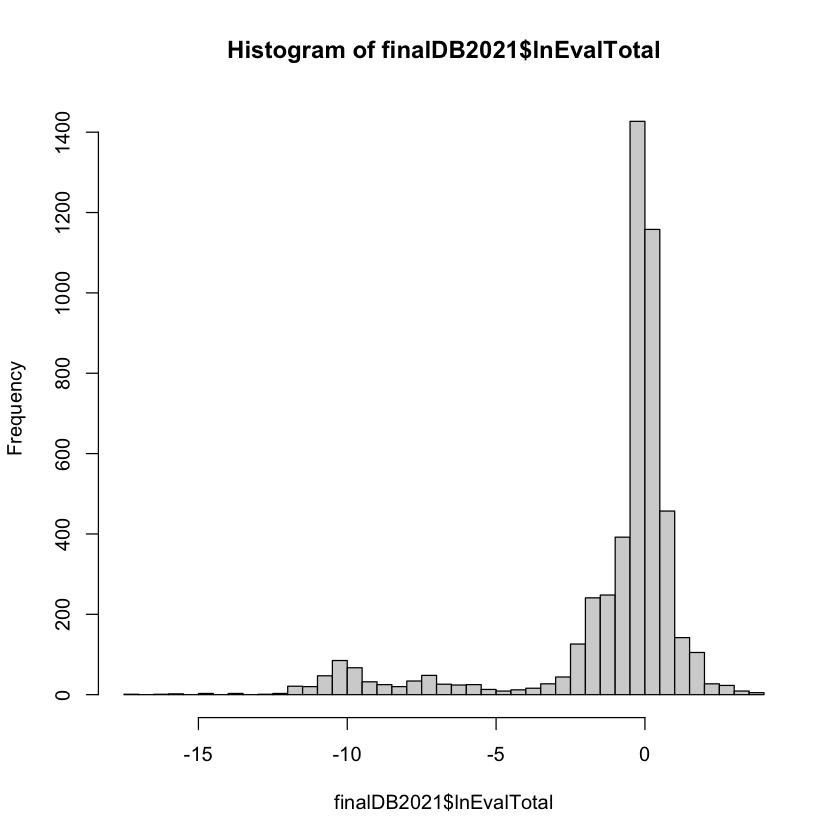

In [190]:
plot(finalDBoct2019$lnEvalTotal, main = "0ct2019")
print("Standard Deviation")
print(sd(finalDB$EvalTotal))
hist(finalDBoct2019$lnEvalTotal, breaks = 50)

plot(finalDB2019$lnEvalTotal, main = "2019")
print("Standard Deviation")
print(sd(finalDB2019$EvalTotal))
hist(finalDB2019$lnEvalTotal, breaks = 50)

plot(finalDB2020$lnEvalTotal, main = "2020")
print("Standard Deviation")
print(sd(finalDB2020$EvalTotal))
hist(finalDB2020$lnEvalTotal, breaks = 50)

plot(finalDB2021$lnEvalTotal, main = "2021")
print("Standard Deviation")
print(sd(finalDB2021$EvalTotal))
hist(finalDB2021$lnEvalTotal, breaks = 50)


In [170]:
finalDB2019[order(-EvalTotal)]

Datasource,Month,Country,Cost.Type,Campaign.Name,Cost.KPI,N,Platform.Cost,Impressions,Clicks,⋯,Central.Video.Views,Eval1,Eval2,Eval3,Eval4,Eval5,Eval6,EvalTotal,second.Eval,first.Eval
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Facebook Ads Insights,2020-05-28,GTM,CPM,MCMMIA_2020_GTM_KELLOGGS_PRINGLES_SEASONAL_STAYHOME&CAEMEJOR_FACEBOOK_FACEBOOKANDINSTAGRAM_REACH_CPM_EVENINGME,Impressions,1,211.8100,550005,5233,⋯,0,-0.0009327418,2.6624310,0.000000e+00,14631.000000,0.000000,0.00000,148.97150,1.463100e+02,2.6624310
Facebook Ads Insights,2019-08-14,MEX,CPC,MCMMIA_2019_MEX_KELLOGGS_HAZLOTUYO_SEASONAL_HAZLOTUYO_FACEBOOK_FACEBOOK_WEBSITECLICKS_CPC_BREAKFASTFORONE,Clicks,1,273.8900,356924,5909,⋯,0,-0.8659039387,0.2385238,1.158627e+02,0.000000,0.000000,0.00000,114.99687,2.385238e-05,115.8627451
Facebook Ads Insights,2020-05-28,GTM,CPM,MCMMIA_2020_GTM_KELLOGGS_CHOCOKRISPIS_SEASONAL_KOOLCHARAS_FACEBOOK_FACEBOOKANDINSTAGRAM_REACH_CPM_FAMILYBREAKFAST,Impressions,1,131.1900,284002,984,⋯,0,-0.0011188219,1.3747797,0.000000e+00,7400.500000,0.000000,0.00000,75.37866,7.400500e+01,1.3747797
Facebook Ads Insights,2019-08-14,MEX,CPM,MCMMIA_2019_MEX_KELLOGGS_SPECIALK_SEASONAL_ALIMENTAMOSLOQUEERES_FACEBOOK_FACEBOOK_BRANDAWARENESS_CPM_BREAKFASTFORONE,Impressions,1,2805.9300,5693234,31087,⋯,0,-0.0011421205,3.8046522,6.095490e+02,0.000000,0.000000,0.00000,64.75841,6.095490e+01,3.8046522
Facebook Ads Insights,2019-06-27,MEX,CPC,MCMMIA_2019_MEX_KELLOGGS_HAZLOTUYO_SEASONAL_HAZLOTUYO_FACEBOOK_FACEBOOK_WEBSITECLICKS_CPC_BREAKFASTFORONE,Clicks,1,891.1200,1041102,24868,⋯,0,-0.5479966215,0.8423956,1.923577e+00,594.225352,0.000000,0.00000,60.79820,5.942262e+01,1.9235767
Facebook Ads Insights,2020-05-28,GTM,CPM,MCMMIA_2020_GTM_KELLOGGS_CHOCOKRISPIS_SEASONAL_CHOCOKRISPIS_FACEBOOK_FACEBOOK_REACH_CPM_FAMILYBREAKFAST,Impressions,1,65.4700,209043,1052,⋯,0,-0.0007585572,1.0119227,0.000000e+00,5202.500000,0.000000,0.00000,53.03616,5.202500e+01,1.0119227
Facebook Ads Insights,2021-03-29,MEX,CPCV,MCMMX_2021_MEX_KELLOGGS_EXTRA_SEASONAL_EXTRADELICE_FACEBOOK_FACEBOOKANDINSTAGRAM_VIEWS_CPCV_AFTERNOONSNACK,Video Completions,1,683.7433,268874,1676,⋯,0,-1.1736484586,0.5904828,8.919638e-01,454.729128,2.160906,0.00000,46.46112,4.547386e+01,2.1609057
Facebook Ads Insights,2021-02-25,MEX,CPM,MCMMX_2021_MEX_KELLOGGS_ZUCARITAS_SEASONAL_PURAGARRA_FACEBOOK_FACEBOOKANDINSTAGRAM_REACH_CPM_FAMILYBREAKFAST,Impressions,1,799.6889,1983815,7703,⋯,0,-0.0011779594,1.0000000,3.914126e+00,4442.947368,0.000000,0.00000,45.81971,4.482089e+01,1.0000000
Facebook Ads Insights,2021-02-25,MEX,CPM,MCMMX_2021_MEX_KELLOGGS_MASTERBRAND_SEASONAL_DESPIERTAMUCHOMAS_FACEBOOK_FACEBOOKANDINSTAGRAM_REACH_CPM_BREAKFASTFORONE,Impressions,1,1033.4666,2725494,6776,⋯,0,-0.0011080558,1.3738650,3.443089e+00,4287.578947,0.000000,0.00000,44.59286,4.322010e+01,1.3738650


In [118]:
dailyDB = merge(inDB, central_goal)
dailyDB = merge(dailyDB, global_mes, by=c("Datasource", "Month", "Country"), all.x=TRUE, allow.cartesian=TRUE)


dailyDB$Eval1 = -1*dailyDB$Unit.Cost /dailyDB$Central.Cost
dailyDB$Eval2 = dailyDB$Impressions / dailyDB$Central.Impressions
dailyDB$Eval3 = dailyDB$Clicks / dailyDB$Central.Clicks
dailyDB$Eval4 = dailyDB$Engagements / dailyDB$Central.Engagements
dailyDB$Eval5 = dailyDB$Video.Completions/ dailyDB$Central.Video.Completions
dailyDB$Eval6 = dailyDB$Video.Views / dailyDB$Central.Video.Views

dailyDB[is.na(dailyDB)] <- 0
dailyDB[dailyDB==Inf] <- 0


dailyDB$EvalTotal = 0

dailyDB[Cost.Type == "CPM", EvalTotal:= Eval1 + Eval2 + (0.1*Eval3) + (0.01*Eval4) + (0.001)*Eval5 + (0.0001*Eval6)]
dailyDB[Cost.Type == "CPE", EvalTotal:= Eval1 + Eval4 + (0.1)*Eval6 + (0.01)*Eval5 + (0.001)*Eval3 + (0.0001)*Eval2]
dailyDB[Cost.Type == "CPV", EvalTotal:= Eval1 + (0.1)*Eval4 + Eval6 + (0.01)*Eval5 + (0.001)*Eval3 + (0.0001)*Eval2]
dailyDB[Cost.Type == "CPCV", EvalTotal:= Eval1 + (0.1)*Eval4 + (0.01)*Eval6 + Eval5 + (0.001)*Eval3 + (0.0001)*Eval2]
dailyDB[Cost.Type == "CPC", EvalTotal:= Eval1 + (0.1)*Eval4 + (0.01)*Eval6 + Eval3 + (0.001)*Eval5 + (0.0001)*Eval2]


testcampaign= "MCMMIA_2019_COL_Pringles_Pringles_Seasonal_Mimos_Facebook_FacebookandInstagram_BrandAwareness_CPM_eveningme"

test1 = dailyDB[Campaign.Name %like% testcampaign]
daily19DB = dailyDB[Campaign.Name %like% "BRA"]
daily19DB[, .(.N), by=Campaign.Name]

Campaign.Name,N
<chr>,<int>
KTBO_2020_BRA_PARATI_TRINK_ALWAYSON_ALWAYSON_FACEBOOK_FACEBOOK&INSTAGRAM_AWARENESS_CPM_MIDMORNINGSNACK,93
KTBO_2020_BRA_PARATI_TRINK_ALWAYSON_ALWAYSON_FACEBOOK_INSTAGRAM_AWARENESS_CPM_MIDMORNINGSNACK,5
KTBO_2020_BRA_KELLOGGS_PRINGLES_ALWAYSON_ALWAYSON_FACEBOOK_INSTAGRAM_AWARENESS_CPM_,9
MCMMIA_2020_CENAM_KELLOGGS_MASTERBRAND_SEASONAL_DIADELCEREAL_FACEBOOK_FACEBOOK_REACH_CPM_BREAKFASTFORONE,1
MCMMIA_2020_CENAM_KELLOGGS_MASTERBRAND_SEASONAL_DIADELCEREAL_FACEBOOK_INSTAGRAM_REACH_CPM_BREAKFASTFORONE,1
KTBO_2020_BRA_KELLOGGS_PRINGLES_SEASONAL_QUESACO_FACEBOOK_FACEBOOK_AWARENESS_CPM_EVENINGLEISURETIME,125
KTBO_2020_BRA_KELLOGGS_PRINGLES_ALWAYSON_ALWAYSON_FACEBOOK_INSTAGRAM_AWARENESS_CPM_EVENINGLEISURETIME,88
MCMMIA_2020_MEX_KELLOGGS_MASTERBRAND_SEASONAL_CORONAVIRUS_FACEBOOK_FACEBOOKANDINSTAGRAM_REACH_CPM_BREAKFASTFORONE,80
MCMMIA_2020_CENAM_KELLOGGS_MASTERBRAND_SEASONAL_CHEEZIT_FACEBOOK_FACEBOOK_REACH_CPM_BREAKFASTFORONE,12


Warning message in min(x):
“ningún argumento finito para min; retornando Inf”
Warning message in max(x):
“ningun argumento finito para max; retornando -Inf”
Warning message in min(x):
“ningún argumento finito para min; retornando Inf”
Warning message in max(x):
“ningun argumento finito para max; retornando -Inf”


ERROR: Error in plot.window(...): se necesitan valores finitos de 'xlim'


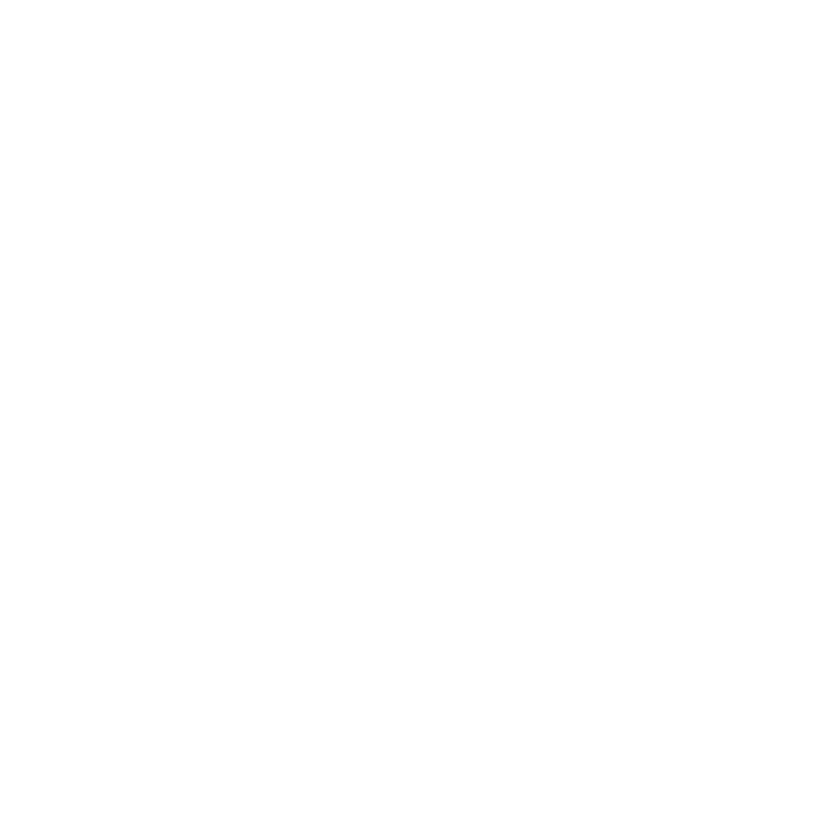

In [119]:
plot(test1$Daily, test1$EvalTotal, main="Metric performance in time (2019)", xlab="Time",ylab="K-WIN", sub=testcampaign, font.main=4, cex.sub=0.97)
lines(smooth.spline(test1$Daily, test1$EvalTotal))

dev.print(png, file = "example.png", width = 1076, height = 768, bg="transparent")
dev.off()

In [58]:
sum(inDB$Platform.Cost....)

[1] 9047882

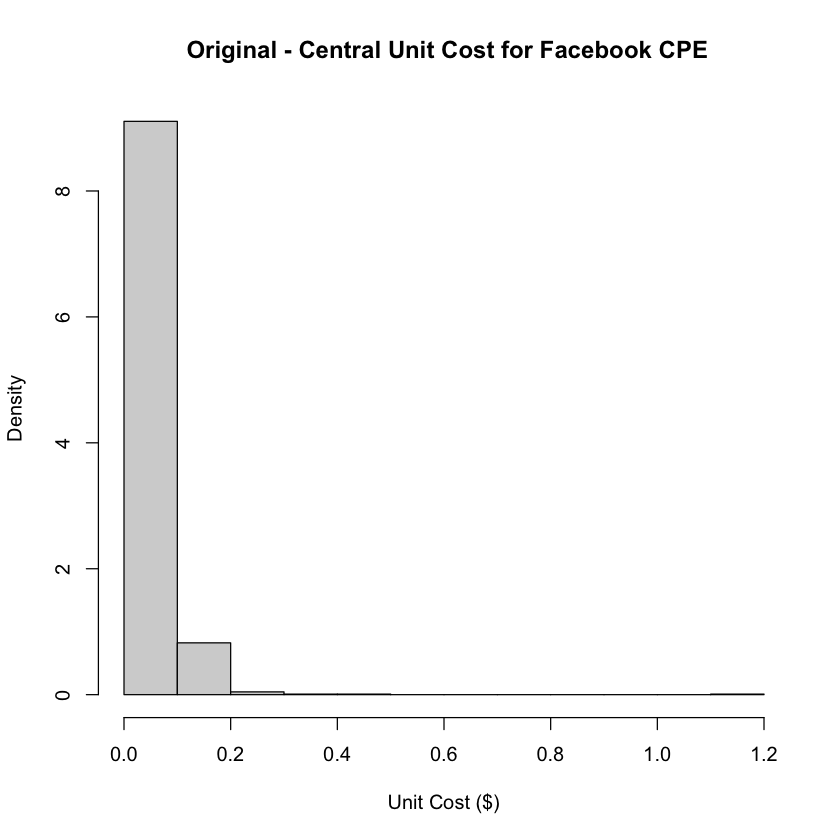

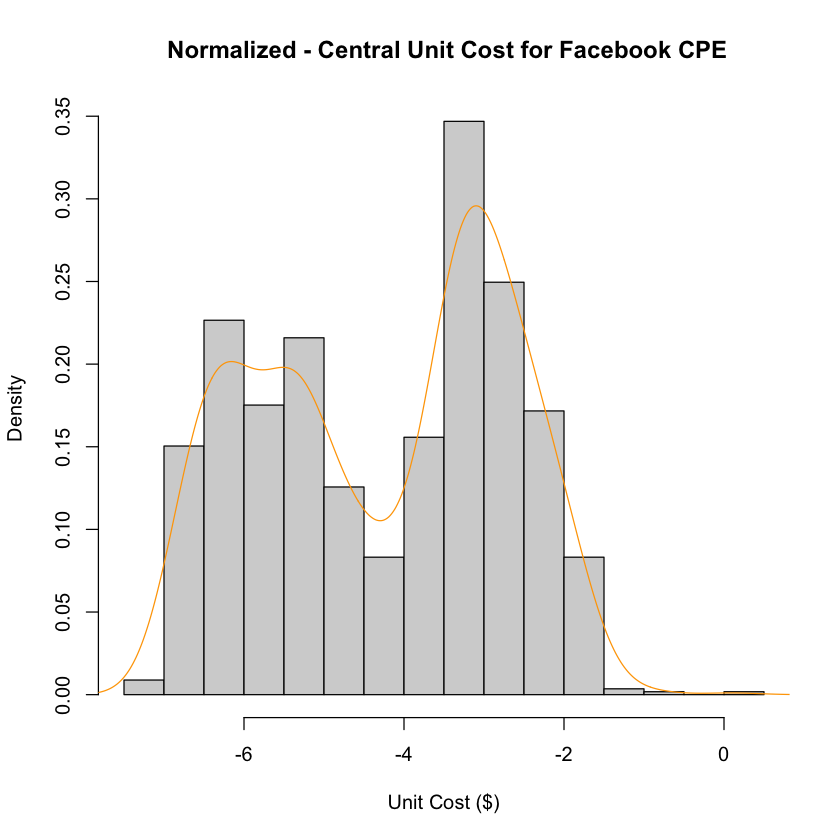

In [59]:
hist(inDB[Datasource %like% "Facebook" & Cost.Type == "CPE"]$Unit.Cost, prob=TRUE, main=" Original - Central Unit Cost for Facebook CPE", xlab="Unit Cost ($)")
hist(log(inDB[Datasource %like% "Facebook" & Cost.Type == "CPE"]$Unit.Cost), prob=TRUE, main=" Normalized - Central Unit Cost for Facebook CPE", xlab="Unit Cost ($)")
lines(density(log(inDB[Datasource %like% "Facebook" & Cost.Type == "CPE"]$Unit.Cost)), col="orange")

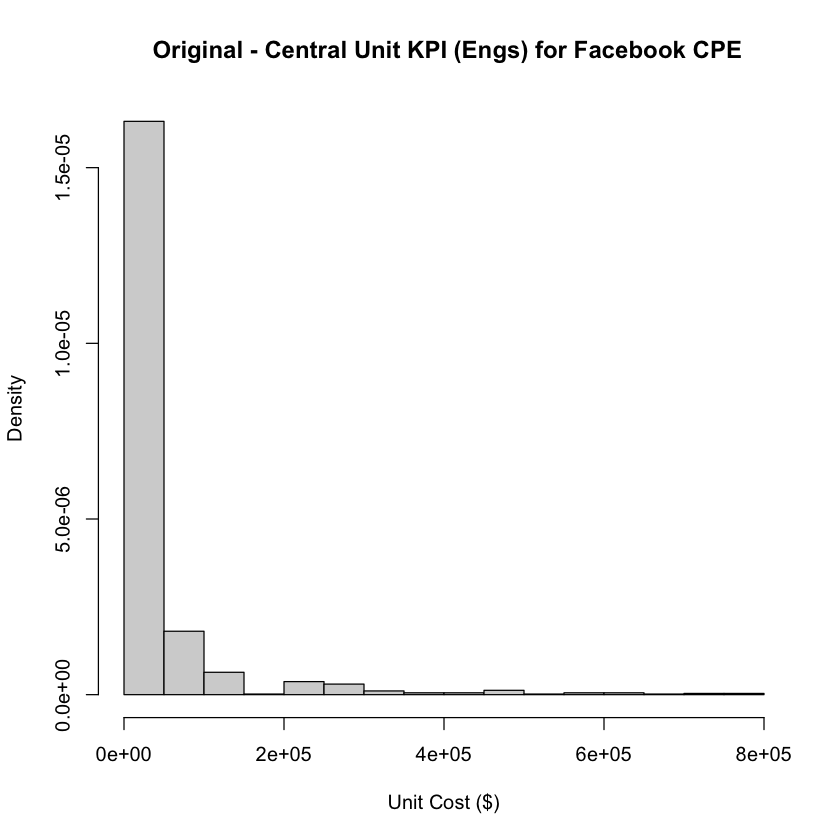

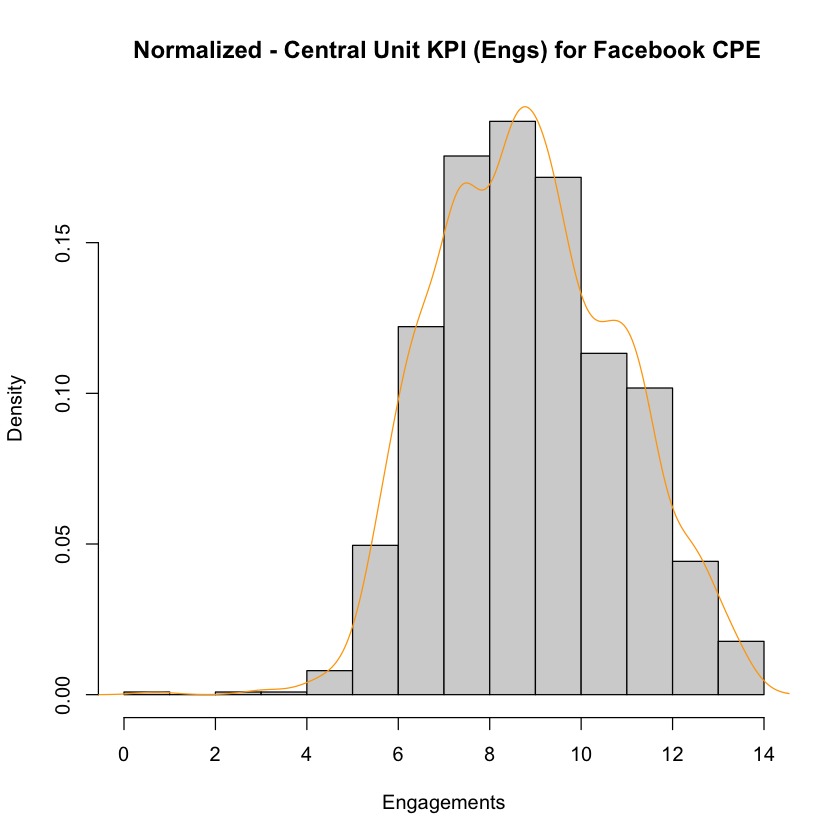

In [60]:
hist(inDB[Datasource %like% "Facebook" & Cost.Type == "CPE"]$Unit.KPI, prob=TRUE, main=" Original - Central Unit KPI (Engs) for Facebook CPE", xlab="Unit Cost ($)")
hist(log(inDB[Datasource %like% "Facebook" & Cost.Type == "CPE"]$Unit.KPI), prob=TRUE, main=" Normalized - Central Unit KPI (Engs) for Facebook CPE", xlab="Engagements")
lines(density(log(inDB[Datasource %like% "Facebook" & Cost.Type == "CPE"]$Unit.KPI)), col="orange")

In [14]:
median(presDB$Eval)*0.7
median(presDB$Eval)*1.3

[1] 2.061144

[1] 3.827839

In [15]:
finalDB[Campaign.Name %like% "CPV", .(.N), by=Campaign.Name]

Campaign.Name,N
<chr>,<int>
MCMMIA_2021_COL_KELLOGGS_PRINGLES_SEASONAL_ALWAYSON_FACEBOOK_FACEBOOKANDINSTAGRAM_VIEWS_CPV_EVENINGME,1
KTBO_2020_BRA_KELLOGGS_SUCRILHOS_SEASONAL_GOOGLE_YOUTUBE_TIGER_AFFINITYTOPICS_CPV_MORNINGBREAKFAST,2
MCMMIA_2020_COL_KELLOGGS_FROOTLOOPS_SEASONAL_GOOGLE_YOUTUBE_FROOTLOOPSJUMBO_AFFINITYAUDIENCES_CPV_MID-MORNINGSNACK,1
MCMMIA_2020_COL_KELLOGGS_MASTERBRAND_SEASONAL_GOOGLE_YOUTUBE_INCANSABLES_AFFINITYAUDIENCES_CPV_BREAKFASTFORONE,1
MCMMIA_2020_COL_KELLOGGS_EXTRA_SEASONAL_GOOGLE_YOUTUBE_EXTRA_AFFINITYAUDIENCES_CPV_BREAKFASTFORONE,1
MCMMIA_2020_COL_KELLOGGS_CHOCOKRISPIS_SEASONAL_GOOGLE_YOUTUBE_EXPERIENCIACHOCOKRISPIS_AFFINITYAUDIENCES_CPV_FAMILYBREAKFAST,1
MCMMIA_2020_CRI_KELLOGGS_MASTERBRAND_SEASONAL_GOOGLE_YOUTUBE_DESPIERTAMUCHOMAS_AFFINITYAUDIENCES_CPV_BREAKFASTFORONE,1
MCMMIA_2020_CRI_KELLOGGS_FROOTLOOPS_SEASONAL_GOOGLE_YOUTUBE_FROOTLOOPSJUMBO_AFFINITYAUDIENCES_CPV_MID-MORNINGSNACK,1
MCMMIA_2020_CRI_KELLOGGS_MASTERBRAND_SEASONAL_GOOGLE_YOUTUBE_HAGAMOSFAMILIA_AFFINITYAUDIENCES_CPV_BREAKFASTFORONE,1


In [16]:
finalDB[Campaign.Name=="MCMMIA_2020_CRI_Kelloggs_Pringles_Seasonal_Google_Youtube_MovimientoPringles_PlacementsVideos_CPV_EveningMe"][order(Month)]

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


Datasource,Month,Country,Cost.Type,Campaign.Name,Cost.KPI,N,Platform.Cost,Impressions,Clicks,⋯,Central.Impressions,Central.Video.Completions,Central.Video.Views,Eval1,Eval2,Eval3,Eval4,Eval5,Eval6,EvalTotal
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


In [17]:
finalDB

Datasource,Month,Country,Cost.Type,Campaign.Name,Cost.KPI,N,Platform.Cost,Impressions,Clicks,⋯,Central.Impressions,Central.Video.Completions,Central.Video.Views,Eval1,Eval2,Eval3,Eval4,Eval5,Eval6,EvalTotal
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Facebook Ads Insights,2020-09,BRA,CPM,KTBO_2020_BRA_KELLOGGS_SUCRILHOS_SEASONAL_TIGER_FACEBOOK_FACEBOOK_AWARENESS_CPM_MORNINGBREAKFAST,Impressions,30,57057.918,134539752,293113,⋯,2960763.0,0.0,0,-0.0008934693,45.440906,0.0000000,0.00000,0.0000000,0,45.440012
Facebook Ads Insights,2020-09,BRA,CPM,KTBO_2020_BRA_KELLOGGS_SUCRILHOS_SEASONAL_TIGER_FACEBOOK_INSTAGRAM_AWARENESS_CPM_MORNINGBREAKFAST,Impressions,30,49301.999,70219589,66233,⋯,2960763.0,0.0,0,-0.0014791785,23.716721,0.0000000,0.00000,0.0000000,0,23.715241
Facebook Ads Insights,2020-09,BRA,CPM,KTBO_2020_BRA_KELLOGGS_PRINGLES_ALWAYSON_ALWAYSON_FACEBOOK_INSTAGRAM_AWARENESS_CPM_EVENINGLEISURETIME,Impressions,13,7587.387,50896227,37080,⋯,2960763.0,0.0,0,-0.0003140661,17.190240,0.0000000,0.00000,0.0000000,0,17.189926
Facebook Ads Insights,2020-09,BRA,CPM,KTBO_2020_BRA_KELLOGGS_PRINGLES_SEASONAL_QUESACO_FACEBOOK_FACEBOOK_AWARENESS_CPM_EVENINGLEISURETIME,Impressions,10,11551.107,16881612,37972,⋯,2960763.0,0.0,0,-0.0014415311,5.701778,0.0000000,0.00000,0.0000000,0,5.700336
Facebook Ads Insights,2020-09,COL,CPC,MCMMIA_2020_COL_KELLOGGS_CHOCOKRISPIS_SEASONAL_EXPERIENCIACHOCOKRISPIS_FACEBOOK_FACEBOOKANDINSTAGRAM_WEBSITECLICKS_CPC_FAMILYBREAKFAST,Clicks,6,538.000,1850653,24563,⋯,338803.0,1263.5,0,-0.9946469324,5.462328,5.9785810,0.00000,59.5298773,0,5.044010
Facebook Ads Insights,2020-09,COL,CPCV,MCMMIA_2020_COL_KELLOGGS_EXTRA_SEASONAL_EXTRA_FACEBOOK_FACEBOOKANDINSTAGRAM_VIDEOVIEWS_CPCV_BREAKFASTFORONE,Video Completions,10,1708.920,1264083,9558,⋯,338803.0,1263.5,0,-1.0054315445,3.731027,2.3263965,0.00000,10.2952117,0,9.292480
Facebook Ads Insights,2020-09,COL,CPM,MCMMIA_2020_COL_KELLOGGS_FROOTLOOPS_SEASONAL_FROOTLOOPSJUMBO_FACEBOOK_FACEBOOKANDINSTAGRAM_REACH_CPM_MID-MORNINGSNACK,Impressions,30,1980.000,10574453,24067,⋯,338803.0,1263.5,0,-0.0011078415,31.211214,5.8578557,0.00000,39.2196280,0,31.835112
Facebook Ads Insights,2020-09,COL,CPM,MCMMIA_2020_COL_KELLOGGS_MASTERBRAND_SEASONAL_INCANSABLES_FACEBOOK_FACEBOOKANDINSTAGRAM_REACH_CPM_BREAKFASTFORONE,Impressions,30,1107.000,9300661,11634,⋯,338803.0,1263.5,0,-0.0007042132,27.451531,2.8316904,0.00000,40.1788682,0,27.774175
Facebook Ads Insights,2020-09,COL,CPM,MCMMIA_2020_COL_KELLOGGS_EXTRA_SEASONAL_EXTRA_FACEBOOK_INSTAGRAM_REACH_CPM_BREAKFASTFORONE,Impressions,10,920.460,4208729,2173,⋯,338803.0,1263.5,0,-0.0012939703,12.422349,0.5289035,0.00000,0.1859913,0,12.474131


In [ ]:
kwi